In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## About this Dataset

This data has been collected from two solar power plants in India over a 34-day period. It represents both power generation and weather data from two distinct plants. The power generation datasets are collected at the inverter level, with each inverter connected to multiple lines of solar panels. Weather data is gathered using sensors positioned at the plant level, utilizing a single array of sensors strategically placed within each plant.


#### Power generation dataset :
- **DATE_TIME**: Timestamp representing the date and time of the recorded data point.
- **PLANT_ID**: A unique identifier for the solar power plant from which the data was collected.
- **SOURCE_KEY**: A unique identifier for each inverter (Inverters are responsible for converting DC power into AC power).
- **DC_POWER**: The direct current (DC) power generated by the solar panels.
- **AC_POWER**: The alternating current (AC) power generated by the solar panels after conversion.
- **DAILY_YIELD**: The cumulative daily energy yield from the solar panels, often measured in (kWh).
- **TOTAL_YIELD**: The cumulative total energy yield from the solar panels over the entire period of data collection.

#### Weather dataset :
- **DATE_TIME**: A timestamp, as in the power data, representing the date and time of the recorded weather data.
- **PLANT_ID**: The same unique identifier for the solar power plant as in the power data.
- **SOURCE_KEY**: a single inverter is used in the weather measurment, thus a unique value.
- **AMBIENT_TEMPERATURE**: The ambient temperature (°C) at the solar power plant location.
- **MODULE_TEMPERATURE**: The temperature (°C) of the solar panel modules.
- **IRRADIATION**: The level of solar irradiation, or solar energy received at the location, often measured in W/m².

**NOTE**: After a preliminary examination of both plant datasets, it is evident that the second plant's data exhibits a significant number of missing values, with up to 30% of the power generation data being incomplete. As a result, I have chosen to focus exclusively on the data from plant 1 for this study, which has a more manageable 5% rate of missing values.


## Load and Clean data

In [3]:
power_data = pd.read_csv("./Plant_1_Generation_Data.csv")
weather_data = pd.read_csv("./Plant_1_Weather_Sensor_Data.csv")

### 1- Power generation data

In [4]:
power_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [5]:
power_data.shape

(68778, 7)

In [6]:
power_data.dtypes

DATE_TIME       object
PLANT_ID         int64
SOURCE_KEY      object
DC_POWER       float64
AC_POWER       float64
DAILY_YIELD    float64
TOTAL_YIELD    float64
dtype: object

In [7]:
# the feature "PLANT_ID" seems to have the same value 4136001 and thus should be safely dropped
print("feature 'PLANT_ID' count:", len(power_data["PLANT_ID"].unique()))
power_data = power_data.drop(["PLANT_ID"], axis=1)

feature 'PLANT_ID' count: 1


In [8]:
# there are 22 inverters in this plant
inverters = power_data["SOURCE_KEY"].unique()
print(f"Plant inverter count: {len(inverters)}")
print(f"Plant inverters:\n {inverters}")

Plant inverter count: 22
Plant inverters:
 ['1BY6WEcLGh8j5v7' '1IF53ai7Xc0U56Y' '3PZuoBAID5Wc2HD' '7JYdWkrLSPkdwr4'
 'McdE0feGgRqW7Ca' 'VHMLBKoKgIrUVDU' 'WRmjgnKYAwPKWDb' 'ZnxXDlPa8U1GXgE'
 'ZoEaEvLYb1n2sOq' 'adLQvlD726eNBSB' 'bvBOhCH3iADSZry' 'iCRJl6heRkivqQ3'
 'ih0vzX44oOqAx2f' 'pkci93gMrogZuBj' 'rGa61gmuvPhdLxV' 'sjndEbLyjtCKgGv'
 'uHbuxQJl8lW7ozc' 'wCURE6d3bPkepu2' 'z9Y9gH1T5YWrNuG' 'zBIq5rxdHJRwDNY'
 'zVJPv84UY57bAof' 'YxYtjZvoooNbGkE']


In [9]:
# change the inverters names for simplicity
power_data["INVERTER"] = power_data["SOURCE_KEY"].map({v: f'INV_{k}' for k, v in enumerate(inverters)})
power_data = power_data.drop(["SOURCE_KEY"], axis=1)

In [10]:
# verify missing data for each inverter data
expected_sample_per_inverter = 34*24*4 # (34days with a 15min sampling period) 
(power_data["INVERTER"].value_counts() / expected_sample_per_inverter) * 100 

INVERTER
INV_10    96.660539
INV_0     96.629902
INV_3     95.986520
INV_5     95.986520
INV_7     95.894608
INV_12    95.894608
INV_18    95.772059
INV_17    95.772059
INV_16    95.741422
INV_13    95.741422
INV_11    95.741422
INV_14    95.710784
INV_15    95.710784
INV_4     95.710784
INV_20    95.710784
INV_8     95.680147
INV_1     95.557598
INV_9     95.557598
INV_19    95.557598
INV_6     95.526961
INV_2     95.526961
INV_21    95.098039
Name: count, dtype: float64

It appears that all inverters have missing values, accounting for approximately 5% of the total data.

In [11]:
# Check if all datetimes are present using frequency
power_data["DATE_TIME"] = pd.to_datetime(power_data["DATE_TIME"], format='%d-%m-%Y %H:%M')
print(f"Data datetime frequency : {power_data['DATE_TIME'].unique().freq}")

Data datetime frequency : None


The absence of a returned frequency (None) indicates the presence of missing datetimes. To identify these gaps, we can compare the datetimes in the original dataset with a 15-min date range created for the same time period.

In [12]:
# construct a 34 days with 15min intervals from data start-end dates 
datetimes = power_data["DATE_TIME"]
datetime_fullrange = pd.date_range(start=min(datetimes), end=max(datetimes), freq='15min')
print(f"Missing datetimes: {len(datetime_fullrange.difference(datetimes.unique()))}")

Missing datetimes: 106


### Filling out missing datetimes

It's important to observe that the missing values identified above concerns to the entire dataset. Additionally, when we examined the missing values for individual inverters, we notice that some of them have a higher number of missing samples, indicating a greater number of missing dates.

To address these gaps and complete the missing datetimes for each inverter, we need to separately reindex the datetimes for each inverter and subsequently merge them back together.

In [13]:
fullrange = pd.Series(datetime_fullrange, name='DATE_TIME')

data = []
for inverter in power_data["INVERTER"].unique():
    df = power_data[power_data.INVERTER == inverter]
    df = df.merge(fullrange, on='DATE_TIME', how='right')
    df['INVERTER'] = inverter
    data.append(df)
power_df = pd.concat(data)

In [14]:
# Check new data for missing values
power_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71808 entries, 0 to 3263
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    71808 non-null  datetime64[ns]
 1   DC_POWER     68778 non-null  float64       
 2   AC_POWER     68778 non-null  float64       
 3   DAILY_YIELD  68778 non-null  float64       
 4   TOTAL_YIELD  68778 non-null  float64       
 5   INVERTER     71808 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 3.8+ MB


In [15]:
# check for null values
power_df.isna().sum()

DATE_TIME         0
DC_POWER       3030
AC_POWER       3030
DAILY_YIELD    3030
TOTAL_YIELD    3030
INVERTER          0
dtype: int64

It is expected that the data now contains NaN values, which were introduced when we added all the missing timestamps for each inverter. To use this data, we must first address these missing values using one of the common filling methods: the use of previous/next item or interpolation or using KNN imputer.

Since in our study we need also to considere the weather data which may also contain missing values, we will leave the imputing step for later when we'll have both datasets combined.

### 2- Weather data

In [16]:
weather_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [17]:
print("feature 'PLANT_ID' count:", len(weather_data["PLANT_ID"].unique()))
print("feature 'SOURCE_KEY' count:", len(weather_data["SOURCE_KEY"].unique()))

feature 'PLANT_ID' count: 1
feature 'SOURCE_KEY' count: 1


Earlier, we mentioned that we can omit the 'PLANT_ID' feature since we're working with a single plant. Additionally, we can now exclude the inverter columns ('SOURCE_KEY' feature) from the data, this is because the weather data is collected at the location of one inverter, and we assume it to be consistent across all inverters, accurately representing the entire plant.

In [18]:
weather_data = weather_data.drop(["PLANT_ID", "SOURCE_KEY"], axis=1)

In [19]:
# check if there are missing values
weather_data.isna().sum()

DATE_TIME              0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

In [20]:
# check if there are missing datetimes
weather_data["DATE_TIME"] = pd.to_datetime(weather_data["DATE_TIME"], format='%Y-%m-%d %H:%M:%S')
print(f"Data datetime frequency : {weather_data['DATE_TIME'].unique().freq}")

Data datetime frequency : None


In [21]:
datetimes = weather_data["DATE_TIME"]
datetime_fullrange = pd.date_range(start=min(datetimes), end=max(datetimes), freq='15min')
print(f"Missing datetimes: {len(datetime_fullrange.difference(datetimes.unique()))}")

Missing datetimes: 82


### Filling out missing datetimes

No datetime frequency indicates that the weather data has also some missing timestamps, which we must add to be able to combine with the power generation data.

In [22]:
cols = weather_data.columns
weather_data = weather_data.set_index('DATE_TIME').reindex(datetime_fullrange).reset_index()
weather_data.columns = cols

In [23]:
weather_data.isna().sum()

DATE_TIME               0
AMBIENT_TEMPERATURE    82
MODULE_TEMPERATURE     82
IRRADIATION            82
dtype: int64

After adding the missing date-times, we see that there are null values introduced in the other features : 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE','IRRADIATION'. These gaps should be filled with the missing values we identified previously in the power generation dataset before proceeding to the modeling phase.

In [24]:
weather_data.head()

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,24.621525,22.165423,0.0


In [25]:
# augment weather data to account for multiple inverters
weather_df = pd.concat([weather_data for i in range(len(inverters))])

In [26]:
# combine the power generation and weather dataframes
data = pd.merge(power_df, weather_data, on="DATE_TIME")

In [27]:
data

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,INVERTER,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0.0,0.0,0.000,6259559.0,INV_0,25.184316,22.857507,0.0
1,2020-05-15 00:00:00,0.0,0.0,0.000,6183645.0,INV_1,25.184316,22.857507,0.0
2,2020-05-15 00:00:00,0.0,0.0,0.000,6987759.0,INV_2,25.184316,22.857507,0.0
3,2020-05-15 00:00:00,0.0,0.0,0.000,7602960.0,INV_3,25.184316,22.857507,0.0
4,2020-05-15 00:00:00,0.0,0.0,0.000,7158964.0,INV_4,25.184316,22.857507,0.0
...,...,...,...,...,...,...,...,...,...
71803,2020-06-17 23:45:00,0.0,0.0,5147.625,7028601.0,INV_17,21.909288,20.427972,0.0
71804,2020-06-17 23:45:00,0.0,0.0,5819.000,7251204.0,INV_18,21.909288,20.427972,0.0
71805,2020-06-17 23:45:00,0.0,0.0,5817.000,6583369.0,INV_19,21.909288,20.427972,0.0
71806,2020-06-17 23:45:00,0.0,0.0,5910.000,7363272.0,INV_20,21.909288,20.427972,0.0


## Exploratory data analysis

In [28]:
# We extract more features from DATE_TIME
data['hour'] = data.DATE_TIME.dt.hour
data['day'] = data.DATE_TIME.dt.dayofyear
data['dayofweek'] = data.DATE_TIME.dt.dayofweek
data['month'] = data.DATE_TIME.dt.month

# Transform 15 min intervals into labels going from 1-96(24*4)
times = data.DATE_TIME.dt.time.unique()
data['interval'] = data.DATE_TIME.dt.time.map({times[i-1]: i for i in range(1, len(times)+1)})

In [29]:
# use data without missing values for the moment
df_na = data[~data.isna()]

### Data Correlation

<Axes: >

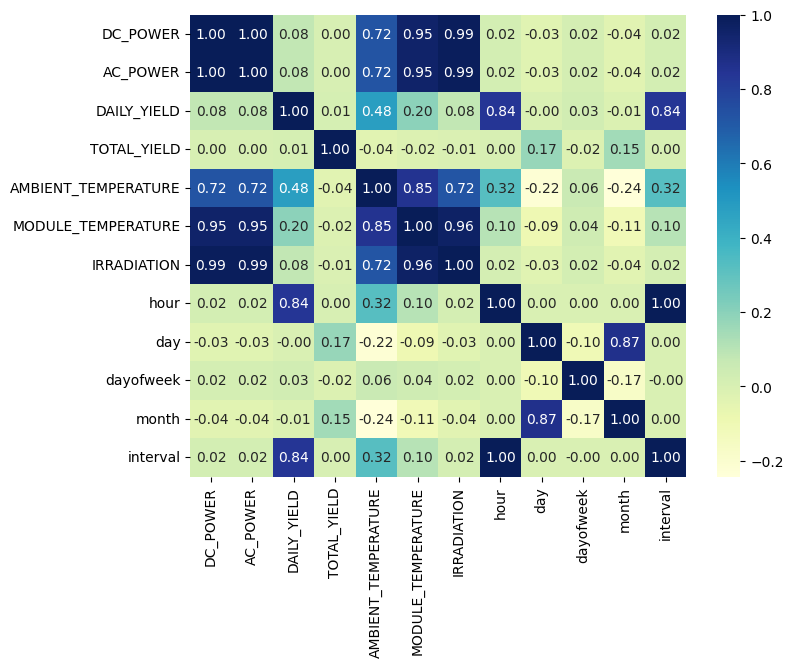

In [30]:
# Let's see the correlation between our features
plt.figure(figsize=(8, 6))
sns.heatmap(df_na.corr(numeric_only=True), cmap='YlGnBu', fmt='.2f', annot=True)

we can extract the following insights:

* High correlation exists between AC and DC power, which is expected because AC power is directly converted from DC power generated by the solar panels. Consequently, when designing the model to predict AC power, it's crucial to exclude DC power from the features to prevent data leakage.

* The more there is sunlight the more power will be generated by the solar panels which is highlighted in the strong relation between DC/AC power generated and irradiation.

* Solar panels are consistently exposed to ambient temperature, explaining the correlation with the module temperature. Although module temperature tends to be higher during power generation.

* The relationship between temperature and sun irradiation is self-evident, requiring no further explanation.

* A clear correlation emerges between daily yield and the time of day (or interval), this relationship is easily explained as the yield begins at zero during nighttime and gradually increases throughout the day due to sun irradiation, ultimately reaching a peak before returning to zero after sunset.

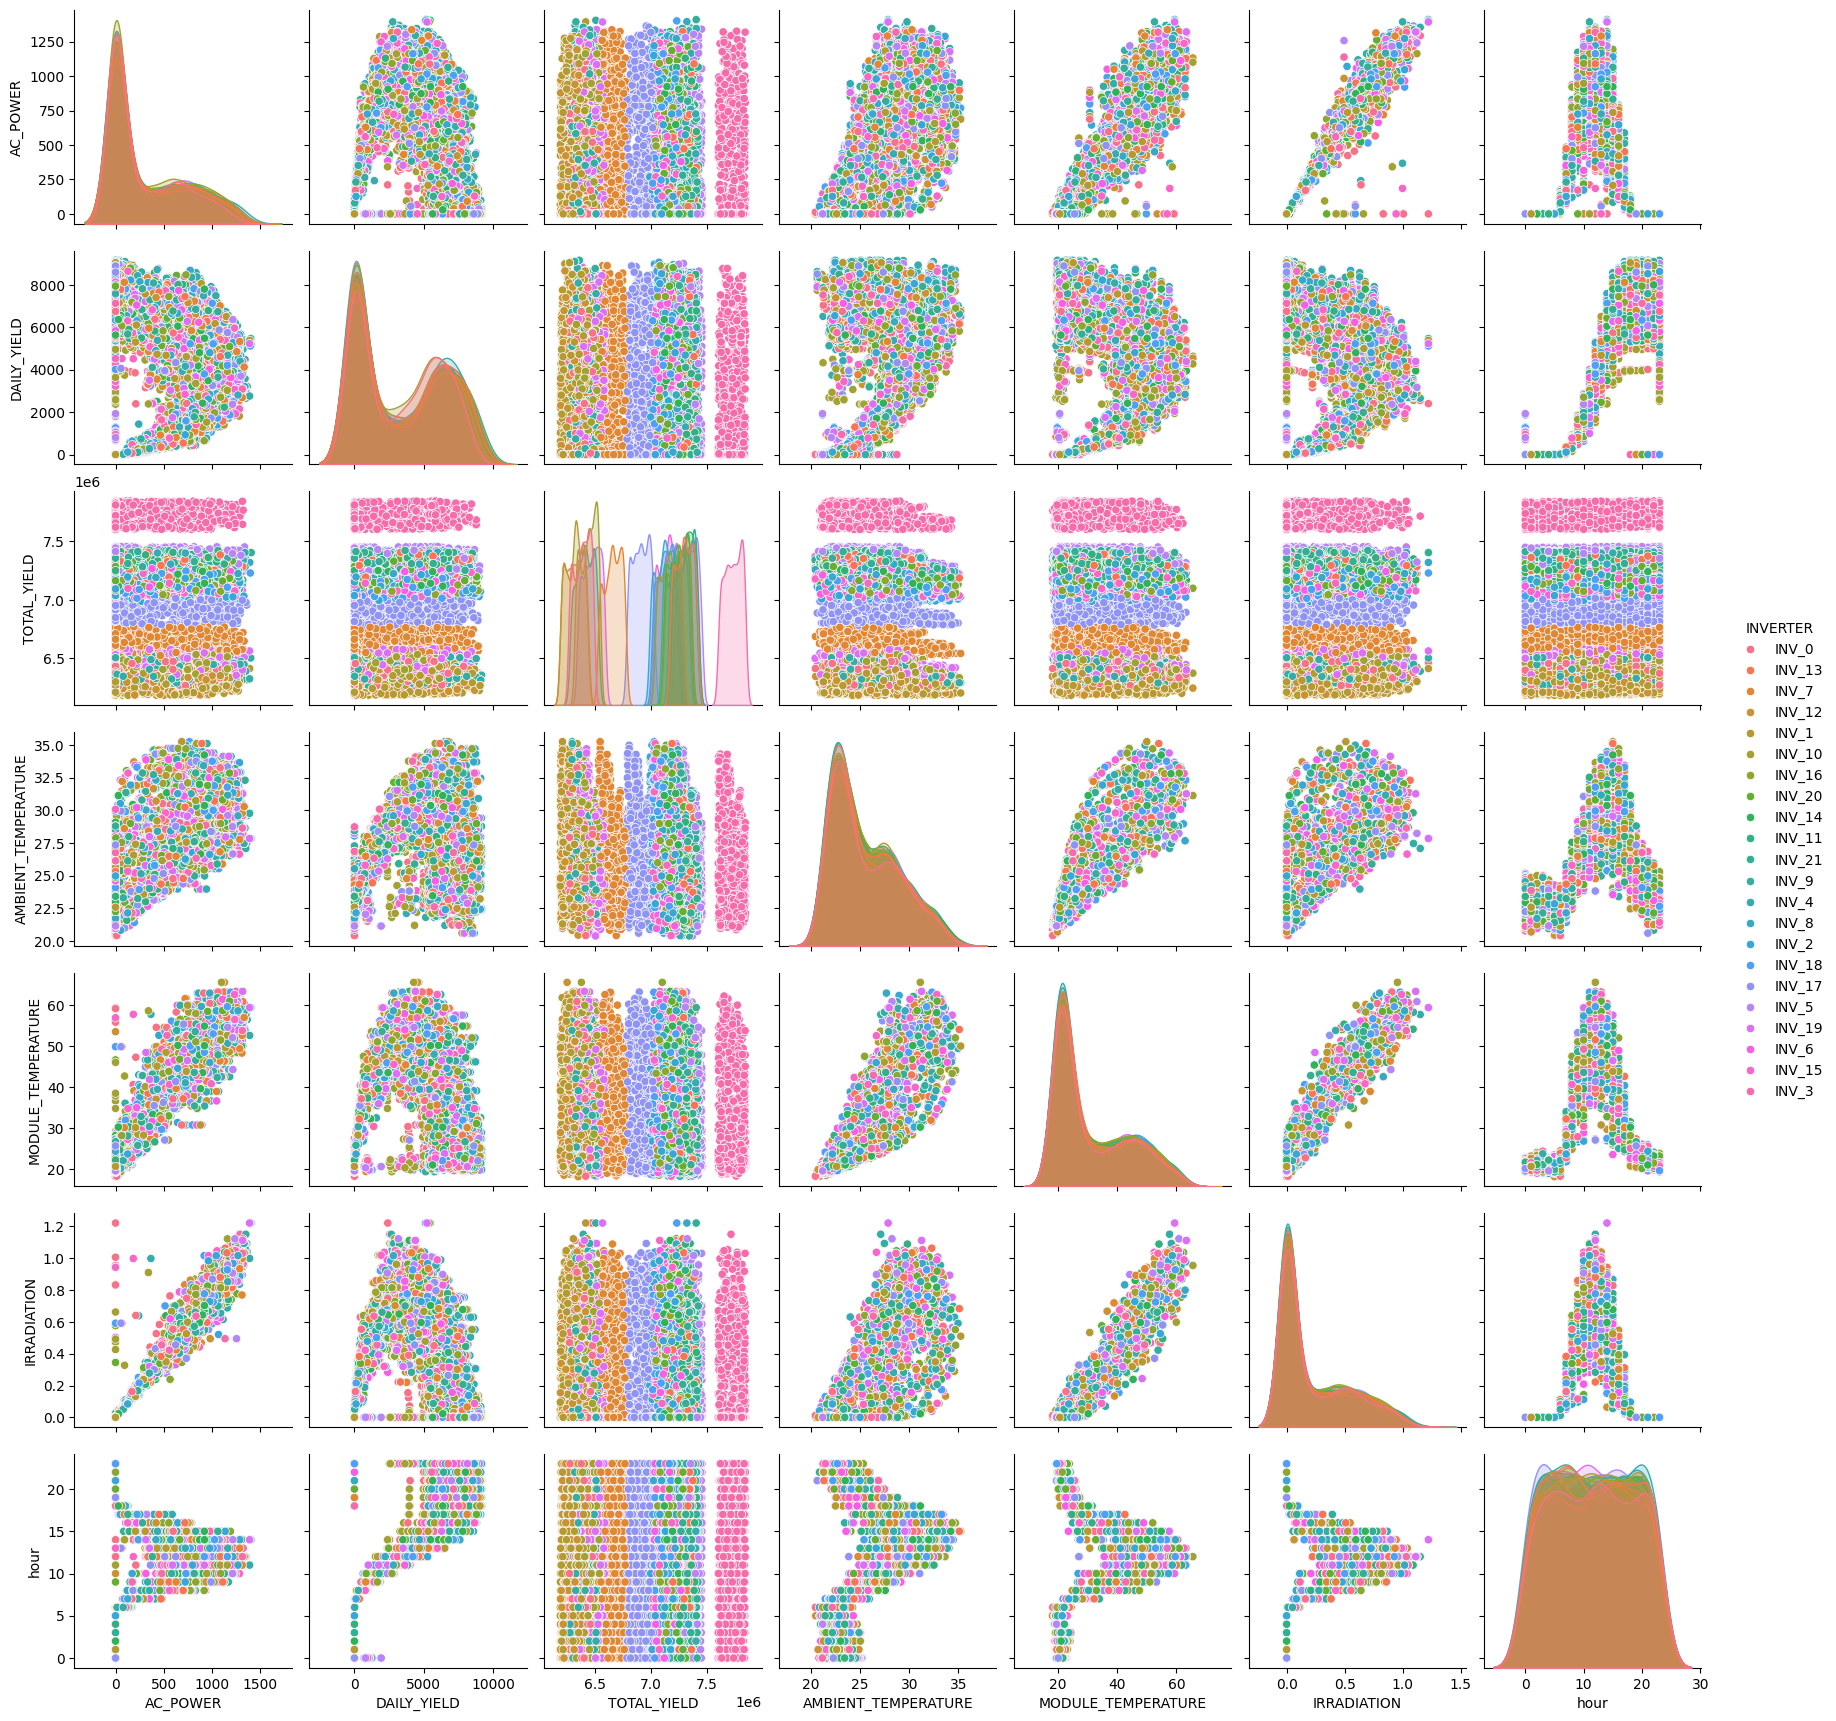

In [31]:
# plot features distribution considering previous correlation
data_dist = data[['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 
                  'MODULE_TEMPERATURE', 'IRRADIATION','hour', 'INVERTER']]
sns.pairplot(data_dist.sample(20000, random_state=0), hue='INVERTER')

* The observed distributions confirm the direct relationships between temperature and irradiation, as well as between AC power/Daily yield and irradiation.

* The evolution of AC power generated throughout the day hours exhibits a bell-shaped curve, with a peak typically occurring around midday, aligning with our expectations under normal conditions.

* AC power and daily yield distributions display a zero-skewness, primarily due to the presence of zero values (absence of sun irradiace) during nighttime when solar panels are inactive.

* There are outliers visible in the AC power and daily yield plots, which should be addressed before modeling stage.

### Removing outliers

Before addressing the numerous missing values within the final dataframe, it's imperative to tackle potential outliers. These outliers may signify either zero yield or power (AC/DC) during daylight hours, or inaccuracies in sensor measurements within the weather data.

In [32]:
def plot_outliers(data, feature):
    """
    Plots outliers for a given feature in the provided data using the percentile method.
    Outliers are detected based on the specified feature and are determined by values 
    falling outside the 1% and 99% percentiles for each interval.

    Parameters:
    - data (DataFrame): The input DataFrame containing the data.
    - feature (str): The name of the feature for which outliers will be detected and plotted.
    """

    df = data.copy()
    df = df.merge(df.groupby('interval')
                .quantile(0.01, numeric_only=True)[feature]\
                .rename('OUTLIERS_LOW'), 
                 on='interval', 
                 how='left')
    df = df.merge(df.groupby('interval')\
                .quantile(0.99, numeric_only=True)[feature]\
                .rename('OUTLIERS_HIGH'), 
                 on='interval', 
                 how='left')
    df = df.merge(df.groupby('interval')\
                .mean(numeric_only=True)[feature]\
                .rename('MEAN'), 
                 on='interval', 
                 how='left')
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(data=df, y=feature, x='interval', hue='INVERTER', 
                    palette='gray', alpha=0.1, legend=False)
    sns.scatterplot(data=df.query(f'{feature} > OUTLIERS_HIGH'), y=feature, x='interval')
    sns.scatterplot(data=df.query(f'{feature} < OUTLIERS_LOW'), y=feature, x='interval') 
    
    plt.ylabel(feature)
    plt.xlabel('Hour of Day')
    ax.set_xticks([i for i in range(1, 97, 4)])
    ax.set_xticklabels([i for i in range(24)])
    ax.legend(['data', 'outliers_high', 'outliers_low'])

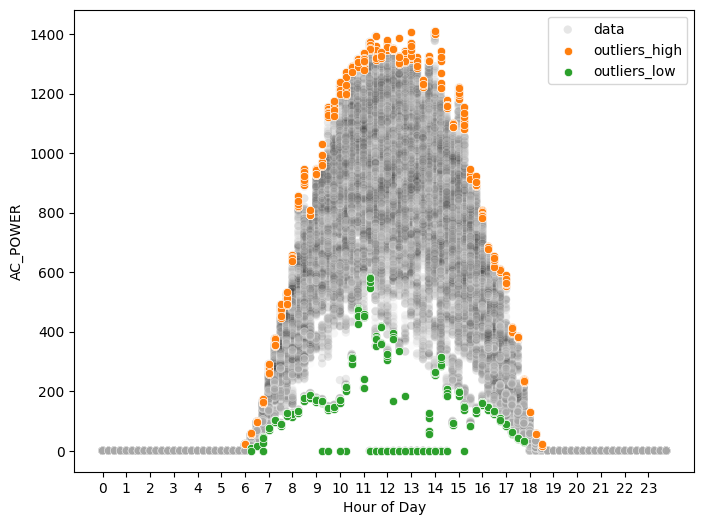

In [33]:
plot_outliers(df_na, "AC_POWER")

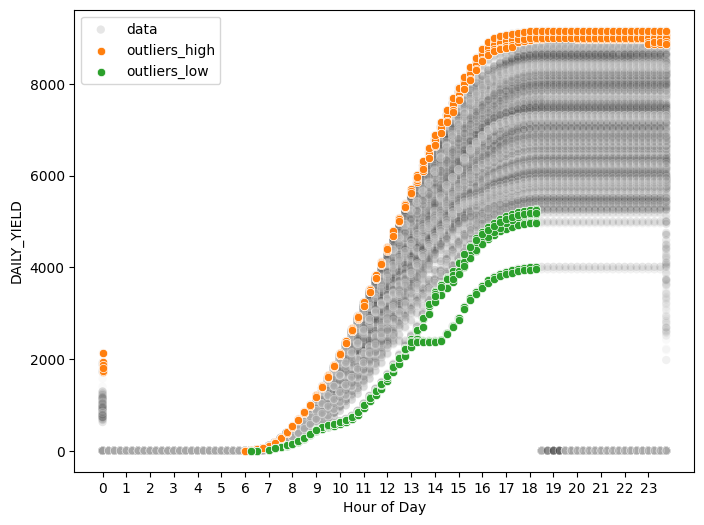

In [34]:
plot_outliers(df_na, "DAILY_YIELD")

* The plot indicates the presence of outliers in the features (considering the specified percentile threshold), these outliers include instances of null power generation values during daytime, which may be attributed to various factors such as measurement inaccuracies, shading, or inverter stopped for maintenance.

* Furthermore, strange values are observed in the daily yield plot, featuring anomalous occurrences, notably zeros occurring after 6:30pm and a column of data points at 0am. These anomalies appear to be incorrect measurements and should be eliminated.

* As for the remaining outlier values, we will treat them as missing data points and handle them during the process of imputing our global dataframe.

### Imputing missing data